In [1]:
import collections
import math
import os
import random
import time
import zipfile
import numpy as np
import urllib
import tensorflow as tf
path = "C:/Users/Cigar/Documents/jupyter/Tensorflow_learn/TFiA/"

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
url = "http://mattmahoney.net/dc/"
def maybe_download(filename, expected_bytes):
    file = path + filename
    if not os.path.exists(file):
        print("downloading...")
        file, _ = urllib.request.urlretrieve(url + filename, file)
    statinfo = os.stat(file)
    if statinfo.st_size == expected_bytes:
        print("Found and verified ", filename)
    else:
        raise Exception("Failed to verify %s. Expected size: %d. Actual size: %d" 
                        % (filename, expected_bytes, statinfo.st_size))
    return file

file = maybe_download("text8.zip", 31344016)

Found and verified  text8.zip


In [3]:
def read_data(file_path):
    with zipfile.ZipFile(file_path) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).lower().split()
    return data

words = read_data(file)
print("Data size: %d" % (len(words)))

Data size: 17005207


In [4]:
# 知乎 Github上的词汇选择， 高频降采与之不同
def preprocess(words, freq_thresh, down_sample=0.001):
    """
    对文本进行预处理和采样。
    Params:
    words: 文本数据，词列表
    freq_thresh: 低词频阈值(低于阈值的低频词会删除)
    down_sample: 高频词降采控制参数
    
    -----
    高频词降采：
    一些常用词的词频很高，在很多时候并不会给予更多的信息。因此对于高频词要给予惩罚。
    对于每个词，计算保留概率pi = (sqrt(fi / t) + 1) * (t / fi)，其中t默认为0.001。
    其中fi为单词频率。
    """
    summary = collections.Counter(words)  # 词频统计 word: count
    total_count = sum(summary.values())  # 总词数
    
    # 生成编码词典和反查词典
    dictionary = {}  # 词汇 -> 编码
    reverse_dictionary = {}  # 编码 -> 词汇
    i = 1
    for word, count in summary.items():
        # 低频降采
        if count < freq_thresh:
            continue
        # 高频降采 subsample
        fi = count / total_count
        pi = (math.sqrt(fi / down_sample) + 1) * (down_sample / fi)  # 保留概率
        rand = random.uniform(0, 1)
        if rand >= pi:
            continue    
        # 如果没有被降采，则加入编码词典
        dictionary[word] = i
        reverse_dictionary[i] = word
        i += 1
    ## 其余单词都标注为 UNK， 且编码为 0
    dictionary["UNK"] = 0
    reverse_dictionary[0] = "UNK"
    
    # 生成词汇编码列表
    def get_index(word):
        try:
            return dictionary[word]
        except KeyError:
            return 0
    
    data = [get_index(word) for word in words]
    
    return data, dictionary, reverse_dictionary

In [7]:
# TFIA 中的词汇选择
def preprocess2(words, vocab_size=50000):
    """
    对文本进行处理，只选取词频较多的词汇，不进行低频、高频降采.
    Params:
    words: 文本数据，词列表。
    vocab_size: 最后生成的词汇词典及反查词典的大小。
    """
    # 词频统计 word: count
    summary = collections.Counter(words).most_common(vocab_size - 1)  # 由于要加入 UNK， 所以实际选择时少一个
    # 生成编码词典和反查词典
    dictionary = {}  # 词汇 -> 编码
    reverse_dictionary = {}  # 编码 -> 词汇
    for index, (word, count) in enumerate(summary):
        dictionary[word] = index + 1
        reverse_dictionary[index + 1] = word
    ## 其余单词都标注为 UNK， 且编码为 0
    dictionary["UNK"] = 0
    reverse_dictionary[0] = "UNK"
    
    # 生成词汇编码列表
    def get_index(word):
        try:
            return dictionary[word]
        except KeyError:
            return 0
    
    data = [get_index(word) for word in words]
    
    return data, dictionary, reverse_dictionary

In [8]:
data, dictionary, reverse_dictionary = preprocess2(words, vocab_size=50000)
print(len(dictionary))

50000


In [9]:
del words  # 减少内存消耗

In [10]:
# 生成训练 Batch
def get_batches(words, batch_size, window_size=5):
    """
    构造生成样本batch的生成器
    参数:
    words: 单词列表(编码列表)
    batch_size: batch大小
    window_size: 单个单词可生成样本的窗口大小
    """
    # 样本取整
    words = words[: batch_size * (len(words) // batch_size)]   
    total_length = len(words)
    
    for curr in range(0, total_length, batch_size):
        x, y = [], []
        # 当前 batch的样本总集
        batch = words[curr : curr + batch_size]
        length = len(batch)
        for idx in range(length):
            batch_x = [batch[idx]]
            batch_y = get_targets(batch, idx, window_size)
            # 由于 1对多关系， 所以需要统一长度
            x.extend(batch_x * len(batch_y))
            y.extend(batch_y)
        yield x, y
                

def get_targets(batch, idx, window_size):
    """
    根据buff中的相对序号和window大小，生成样本的函数
    ------------------
    参数:
    batch: 当前的总样本集
    idx: 当前单词的在batch中的序号
    window_size: 单个单词可生成样本的窗口大小
    """
    # 随机选择窗口大小， 使更有利于与目标单词更近的单词
    rand_window_size = random.randint(1, window_size)
    # 以防两侧词数不足
    start_point = max(idx - rand_window_size, 0)
    end_point = idx + rand_window_size
    targets = set(batch[start_point : idx] + batch[idx + 1 : end_point + 1])
    
    return list(targets)
    

In [11]:
# 构建网络
train_graph = tf.Graph()
vocab_size = len(reverse_dictionary)  # 全部词数量（one-hot维度）
embedding_size = 128  # 嵌入维度
num_sampled = 64
with train_graph.as_default():
    inputs = tf.placeholder(dtype=tf.int32, shape=[None], name="inputs")
    labels = tf.placeholder(dtype=tf.int32, shape=[None, 1], name="labels")
    # 嵌入层的权重矩阵 vocab_size * embedding_size
    embedding = tf.Variable(tf.random_uniform(shape=[vocab_size, embedding_size], minval=-1.0, maxval=1.0))
    # 张量索引查询，batch_size * embedding_size
    embed = tf.nn.embedding_lookup(embedding, inputs)  
    
    # 负采样，解决优化速率慢的问题
    softmax_w = tf.Variable(tf.truncated_normal(shape=[vocab_size, embedding_size], stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(shape=[vocab_size]))
    
    # 计算 neg sample loss: an underestimate of full softmax loss
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=softmax_w, 
                                                     biases=softmax_b, 
                                                     labels=labels, 
                                                     inputs=embed, 
                                                     num_sampled=num_sampled, 
                                                     num_classes=vocab_size))
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)
    
    # 验证词间的相似度（余弦）
#     valid_size = 16
#     valid_window = 100
#     ## 从不同位置择选单词
#     valid_examples1 = np.array(random.sample(range(valid_window), valid_size // 2))
#     valid_examples2 = np.array(random.sample(range(1000, 1000 + valid_window), valid_size // 2))
#     valid_examples = np.r_[valid_examples1, valid_examples2]
    ## 待验证单词集
    valid_words = ["five", "state", "were", "man", "woman", "elephant", "banana", "car", "math", "moon"]
    valid_examples = np.array([dictionary[word] for word in valid_words])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    ## 计算词向量的模并标准化
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), axis=1, keep_dims=True))
    normalized_embedding = embedding / norm
    ## 查找验证单词的词向量
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    
    ## 计算余弦相似度，由于都标准化了所以分母不用计算
    ## 相似度矩阵，valid_size * vocab_size
    ## 每行对应 valid_examples的每个单词（标号），每列为该单词与各单词的相似度
    similarity = valid_embedding @ tf.transpose(normalized_embedding)
    

In [12]:
epochs = 10
batch_size = 2000
window_size = 1
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7  # 程序最多只能占用指定gpu70%的显存
config.gpu_options.allow_growth = True      #程序按需申请内存

with train_graph.as_default():
    saver = tf.train.Saver()  # 文件存储
    init = tf.global_variables_initializer()

with tf.Session(graph=train_graph, config=config) as sess:
    iteration = 1
    avg_loss = 0
    sess.run(init)

    for epoch in range(epochs):
        batches = get_batches(data, batch_size, window_size)
        start = time.time()

        for batch_x, batch_y in batches:
            bacth_x = np.array(batch_x)
            batch_y = np.array(batch_y)[:, np.newaxis]
            _, train_loss = sess.run([optimizer, loss], feed_dict={inputs: batch_x, labels: batch_y})

            avg_loss += train_loss

            # print summary after each 1000 iters
            if iteration % 1000 == 0:
                end = time.time()
                print("Epoch %d / %d, " % (epoch + 1, epochs), 
                      "Iteration: %d" % (iteration), 
                      "Avg. Train_loss: %.4f" % (avg_loss / 1000), 
                      "%.4f sec / batch" % ((end - start) / 1000))
                ## reset
                avg_loss = 0
                start = time.time()
            # print nearest words to target word after each 10000 iters
            if iteration % 10000 == 0:
                sim = sess.run(similarity)
                for i, idx in enumerate(valid_examples):
                    ## 从反查字典获取当前标号对应的单词
                    valid_word = reverse_dictionary[idx]
                    ## 取最相近的 8个单词
                    top_k = 8
                    ## 由于最近的单词会包含自身，且相似度应该为 1（但不确定是否会排在第一位），所以先多选取 1个
                    arg_sort_list = np.argsort(sim[i, :])[: (top_k + 1)]
                    ## 从这个较小的集合中去掉自身序号，再取前 top_k个
                    nearest = arg_sort_list[arg_sort_list != idx][: top_k]
                    ## 反查实际单词
                    nearest_words = ",".join([reverse_dictionary[x] for x in nearest])
                    print("Nearest to [%s]: %s" % (valid_word, nearest_words))

            iteration += 1
    print("---------------")
    print("word2vec done!")
    save_path = saver.save(sess, path + "Chap07_checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1 / 10,  Iteration: 1000 Avg. Train_loss: 5.2720 0.0176 sec / batch
Epoch 1 / 10,  Iteration: 2000 Avg. Train_loss: 4.5723 0.0170 sec / batch
Epoch 1 / 10,  Iteration: 3000 Avg. Train_loss: 4.3796 0.0170 sec / batch
Epoch 1 / 10,  Iteration: 4000 Avg. Train_loss: 4.2272 0.0169 sec / batch
Epoch 1 / 10,  Iteration: 5000 Avg. Train_loss: 4.1392 0.0170 sec / batch
Epoch 1 / 10,  Iteration: 6000 Avg. Train_loss: 4.0744 0.0170 sec / batch
Epoch 1 / 10,  Iteration: 7000 Avg. Train_loss: 3.9526 0.0145 sec / batch
Epoch 1 / 10,  Iteration: 8000 Avg. Train_loss: 3.9702 0.0137 sec / batch
Epoch 2 / 10,  Iteration: 9000 Avg. Train_loss: 3.9277 0.0069 sec / batch
Epoch 2 / 10,  Iteration: 10000 Avg. Train_loss: 3.8929 0.0137 sec / batch
Nearest to [five]: fauna,affiliations,pitman,hispanics,solely,triumphed,pasteurization,managua
Nearest to [state]: vila,picks,nm,pastime,hring,overtraining,egerton,indictees
Nearest to [were]: inserted,crass,coterminous,engravers,adopts,keenan,detonates,conce

Epoch 7 / 10,  Iteration: 53000 Avg. Train_loss: 3.5578 0.0137 sec / batch
Epoch 7 / 10,  Iteration: 54000 Avg. Train_loss: 3.5574 0.0136 sec / batch
Epoch 7 / 10,  Iteration: 55000 Avg. Train_loss: 3.5423 0.0136 sec / batch
Epoch 7 / 10,  Iteration: 56000 Avg. Train_loss: 3.5263 0.0136 sec / batch
Epoch 7 / 10,  Iteration: 57000 Avg. Train_loss: 3.5368 0.0136 sec / batch
Epoch 7 / 10,  Iteration: 58000 Avg. Train_loss: 3.4616 0.0136 sec / batch
Epoch 7 / 10,  Iteration: 59000 Avg. Train_loss: 3.5016 0.0135 sec / batch
Epoch 8 / 10,  Iteration: 60000 Avg. Train_loss: 3.5127 0.0067 sec / batch
Nearest to [five]: triumphed,fauna,comrade,affiliations,hispanics,gastrointestinal,pasteurization,fermionic
Nearest to [state]: overtraining,vila,picks,watson,conch,trumpeter,indictees,paasikivi
Nearest to [were]: crass,inserted,detonates,coterminous,keenan,adopts,croesus,gaucho
Nearest to [man]: compresses,varepsilon,petit,goon,sanj,bracken,gaul,inflate
Nearest to [woman]: deutschen,artistry,hydr

In [27]:
embed_mat.tofile(path + "Chap07_save/embed_mat.txt", sep="\t")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:371: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


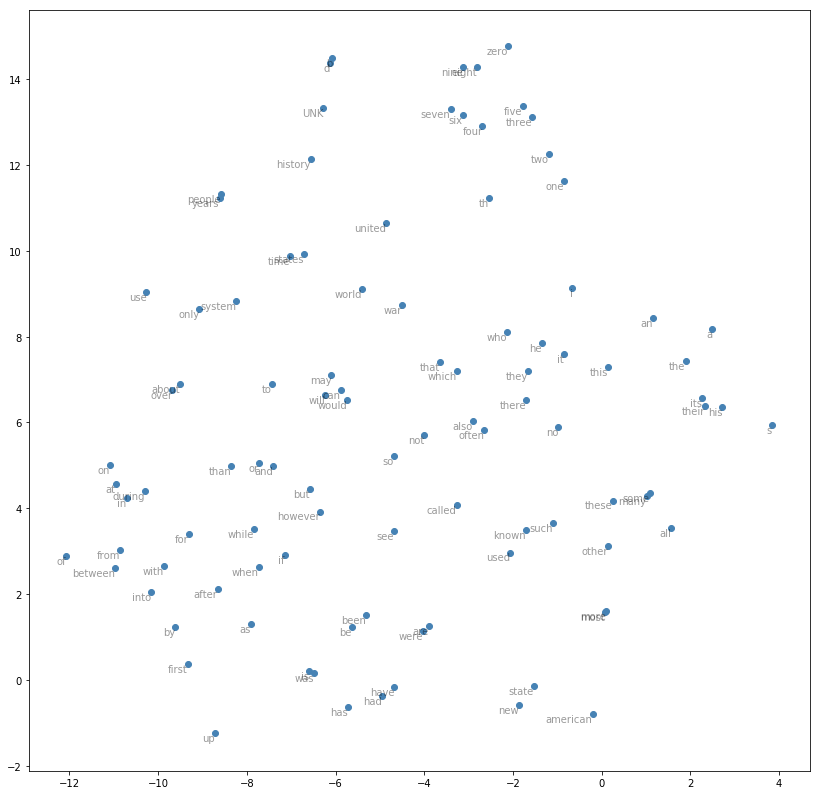

In [29]:
# 词嵌入矩阵的降维展示
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

plot_only = 100
tsne = TSNE(n_components=2, perplexity=30, init="pca", n_iter=5000)
embed_tsne = tsne.fit_transform(embed_mat[:plot_only, :])

fig, ax = plt.subplots(figsize=(14, 14))
for i, vec in enumerate(embed_tsne):
    vec_x, vec_y = vec
    plt.scatter(vec_x, vec_y, color="steelblue")
    plt.annotate(reverse_dictionary[i], (vec_x, vec_y), alpha=0.4, ha="right", va="top")
plt.savefig(path + "Chap07_save/tsne.png")